In [1]:
%matplotlib inline 

In [2]:
import datetime as dt
from pathlib import Path
from typing import Sequence, Tuple, List
import pickle

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics

import matplotlib.pyplot as plt         # ← for progress curves
from IPython.display import display, update_display, clear_output

from tqdm.auto import tqdm          # progress bars that work in Jupyter



In [3]:
ticker = 'AAPL'

df = pd.read_csv(f"dfs training/merged_{ticker}.csv", index_col=0, parse_dates=True)
df

,open,high,low,close,volume,bid,ask,trade_action,StrategyEarning,EarningDiff,signal_smooth_norm
2025-01-02 13:30:00,250.5906,250.6435,250.5244,250.5753,2259.0,250.5001,250.6505,0,0.00,0.000,0.0
2025-01-02 13:31:00,250.5806,250.6317,250.5121,250.5606,2351.0,250.4854,250.6358,0,0.00,0.000,0.0
2025-01-02 13:32:00,250.5712,250.6200,250.4938,250.5453,2455.0,250.4701,250.6205,0,0.00,0.000,0.0
2025-01-02 13:33:00,250.5580,250.6094,250.4762,250.5347,2474.0,250.4595,250.6099,0,0.00,0.000,0.0
2025-01-02 13:34:00,250.5491,250.5994,250.4600,250.5168,2792.0,250.4416,250.5919,0,0.00,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-03 20:56:00,203.2500,203.3500,203.2450,203.3200,189023.0,203.2590,203.3810,0,1.99,0.942,0.0
2025-06-03 20:57:00,203.3200,203.4200,203.3050,203.3800,222383.0,203.3190,203.4410,0,1.99,0.882,0.0
2025-06-03 20:58:00,203.3800,203.4300,203.3322,203.3750,279702.0,203.3140,203.4360,0,1.99,0.887,0.0
2025-06-03 20:59:00,203.3700,203.4100,203.2500,203.3400,724307.0,203.2790,203.4010,0,1.99,0.922,0.0


In [4]:
label_col = "signal_smooth_norm"

feature_cols = ["open", "high", "low", "close", "volume"]
raw_F = len(feature_cols)
look_back = 60
n_feats = raw_F * look_back 

rth_start = dt.time(14, 30) 
save_dir   = Path("dfs training") 
ckpt_path = save_dir / f"best_{ticker}.weights.h5" 

train_prop = 0.7
val_prop = 0.15
batch_size = 1
units = 128

dropout = 0.10
recurrent_dropout = 0.05
initial_lr = 1e-3
min_lr     = 1e-5   # two orders of magnitude lower
loss = "mse"

max_epochs             = 60
early_stop_patience    = 15    # epochs without improvement
lr_reduce_patience     = 5    # epochs without improvement → halve LR

STEPS_PER_PLOT = 20              # refresh tqdm postfix every n trading sessions

In [5]:
# =====================================================================
# build_lstm_tensors                                                   #
# ---------------------------------------------------------------------
# • Converts a multi-day minute-bar DataFrame into leakage-free NumPy   #
#   tensors suitable for our stateful LSTM.                            #
# • One *sample*  = last `look_back` candles ➜ predict current candle. #
# • Windows NEVER cross midnight.                                      #
# • Features are standard-scaled *within each day* to kill day-to-day  #
#   level shifts without leaking information between sessions.         #
# • Output dtype = float32 (saves RAM & plays nice with GPUs).         #
# =====================================================================

def build_lstm_tensors(
    df: pd.DataFrame,
    *,                         # ← force keyword args for safety
    look_back: int,            # length of sliding window (minutes)
    feature_cols: Sequence[str],
    label_col: str,
    rth_start: dt.time,        # e.g. 14:30 CET for US stocks
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Returns
    -------
    X : np.ndarray, shape (samples , look_back·n_feats)
        Flattened window for every RTH bar.
    y : np.ndarray, shape (samples ,)
        One-step-ahead target (same length as samples).
    """

    X_windows, y_targets = [], []             # collectors

    # -------------------------------------------------------------
    # 1) Iterate one calendar day at a time  –– main leak stopper
    # -------------------------------------------------------------
    for _, day_df in df.groupby(df.index.date):

        # --- chronological order is critical for windows ----------
        day_df = day_df.sort_index()

        # --- per-day standardisation of *features* -----------------
        scaler = StandardScaler()
        day_df[feature_cols] = scaler.fit_transform(day_df[feature_cols])

        # --- pull NumPy views (cheap) ------------------------------
        feat_np  = day_df[feature_cols].to_numpy(dtype=np.float32)
        label_np = day_df[label_col]      .to_numpy(dtype=np.float32)

        # --- locate bars inside Regular Trading Hours --------------
        mask_rth = day_df.index.time >= rth_start
        rth_idx  = np.flatnonzero(mask_rth)   # integer positions

        # -----------------------------------------------------------
        # 2) Build sliding windows that stay *within the same day*
        # -----------------------------------------------------------
        for i in rth_idx:
            if i < look_back:            # not enough history yet
                continue

            # rows t-look_back … t-1 become the window
            window_3d = feat_np[i - look_back : i]         # (L , F)

            # ── choose representation ───────────────────────────
            # OPTION A: keep 3-D window  (uncomment next two lines
            #          and comment the "flatten" line if you prefer)
            # X_windows.append(window_3d)
            # ----------------------------------------------------
            # OPTION B: flatten to 1-D (default – lighter & matches
            #          our make_day_dataset reshape)
            X_windows.append(window_3d.reshape(-1))        # (L·F,)
            # ----------------------------------------------------

            y_targets.append(label_np[i])                  # scalar

    # -------------------------------------------------------------
    # 3) Stack lists → final tensors
    # -------------------------------------------------------------
    X = np.stack(X_windows, dtype=np.float32)    # (N , L·F)  or (N , L , F)
    y = np.asarray(y_targets, dtype=np.float32)  # (N ,)

    return X, y


In [6]:
X, y = build_lstm_tensors(df=df,
                         look_back=look_back,         
                         feature_cols=feature_cols,
                         label_col=label_col,
                         rth_start=rth_start)

print(X.shape) # we use 'm' features and 'n' previous look back values to predict each 1 label
print(y.shape) # 'n' lookback values * 'n_days_df' (all pretrade values) are deducted from the original df shape

(40664, 300)
(40664,)


In [7]:
###############################################################################
# chronological_split                                                         #
# --------------------------------------------------------------------------- #
# Purpose                                                                     #
#   Chronologically split the sliding-window tensors (X, y) into              #
#       • train      – first `train_prop`   fraction of *days*                #
#       • validation – next  `val_prop`     fraction of *days*                #
#       • test       – remainder                                              #
#                                                                            #
# Why we have to count *windows per day* again                                #
#   `build_lstm_tensors()` creates `X` by looping minute-by-minute **inside** #
#   each day and it skips the first `look_back` indices (they have no full    #
#   context).  Therefore the number of samples coming out of one day is       #
#                                                                            #
#         (# RTH rows in that day)  minus  (how many of those rows have       #
#                                      global-index  < look_back)            #
#                                                                            #
#   We reproduce exactly that logic here so that the vector `day_id` we build #
#   matches X *one-to-one*.                                                   #
###############################################################################

def chronological_split(
    X: np.ndarray,
    y: np.ndarray,
    df: pd.DataFrame,
    *,
    look_back: int,
    rth_start: dt.time,
    train_prop: float,
    val_prop: float,
) -> Tuple[
        Tuple[np.ndarray, np.ndarray],   # train
        Tuple[np.ndarray, np.ndarray],   # val
        Tuple[np.ndarray, np.ndarray],   # test
        List[int],                       # samples_per_day
        np.ndarray, np.ndarray, np.ndarray   # day_id train/val/test
    ]:
    """
    Parameters
    ----------
    X , y    Sliding-window tensors returned by `build_lstm_tensors`.
    df       Same DataFrame used to create X, y (index = DateTimeIndex).
    look_back
              Length of each window (minutes).
    rth_start
              First bar that counts as a *target* (e.g. 14:30:00 CET).
    train_prop , val_prop
              Fractions of *days* that go into train / val.  Remainder
              becomes the test split.

    Returns
    -------
    (X_train , y_train) , (X_val , y_val) , (X_test , y_test)
    samples_per_day      - list[int] , number of usable windows per day
    day_id_tr , day_id_val , day_id_te
              - arrays mapping each sample back to its calendar day
    """

    # -----------------------------------------------------------------
    # 1) How many windows did each calendar day contribute?
    #    We must replicate the *same* "skip first look_back rows" rule
    #    that build_lstm_tensors() applied, otherwise lengths won't match.
    # -----------------------------------------------------------------
    samples_per_day: List[int] = []

    for _, day_df in df.groupby(df.index.date):
        day_df = day_df.sort_index()                       # chronological

        # integer row numbers of bars that are inside RTH for *this* day
        idx_rth = np.flatnonzero(day_df.index.time >= rth_start)

        # keep only those indices that have at least `look_back` rows of
        # history *within the same day*  (identical IF-condition as before)
        idx_valid = idx_rth[idx_rth >= look_back]

        samples_per_day.append(len(idx_valid))

    # -----------------------------------------------------------------
    # 2) Build `day_id` – one integer tag for every sample in X
    # -----------------------------------------------------------------
    day_id = np.repeat(np.arange(len(samples_per_day)), samples_per_day)

    if len(day_id) != len(X):
        raise ValueError(
            f"Mismatch: day_id length = {len(day_id)}  but  X length = {len(X)}.\n"
            "Check that build_lstm_tensors() and chronological_split() "
            "apply the *same* look_back and rth_start logic."
        )

    # -----------------------------------------------------------------
    # 3) Determine split boundaries in *day space* (not in sample space)
    # -----------------------------------------------------------------
    last_day_index = len(samples_per_day) - 1        # 0-based
    train_cut_day  = int(last_day_index * train_prop)
    val_cut_day    = int(last_day_index * (train_prop + val_prop))

    train_mask =  day_id <= train_cut_day
    val_mask   = (day_id > train_cut_day) & (day_id <= val_cut_day)
    test_mask  =  day_id > val_cut_day

    # -----------------------------------------------------------------
    # 4) Slice tensors
    # -----------------------------------------------------------------
    X_train, y_train = X[train_mask], y[train_mask]
    X_val,   y_val   = X[val_mask],   y[val_mask]
    X_test,  y_test  = X[test_mask],  y[test_mask]

    # -----------------------------------------------------------------
    # 5) Return everything – keeping `day_id` arrays lets downstream
    #    builders (make_day_dataset) stitch windows back into full days.
    # -----------------------------------------------------------------
    return (X_train, y_train), (X_val, y_val), (X_test, y_test), \
           samples_per_day,                                       \
           day_id[train_mask], day_id[val_mask], day_id[test_mask]


In [8]:
(X_tr, y_tr), (X_val, y_val), (X_te, y_te), samples_pd, day_id_tr, day_id_val, day_id_te = \
chronological_split(
                    X, y, df,
                    look_back=look_back,
                    rth_start=rth_start,  
                    train_prop=train_prop,
                    val_prop=val_prop 
                    )

print(f"Per-day windows   : {samples_pd[:5]} …")
print(f"Set shapes        : train {X_tr.shape}, val {X_val.shape}, test {X_te.shape}")
print('day_id_tr', day_id_tr, 'day_id_val', day_id_val, 'day_id_te', day_id_te)

Per-day windows   : [391, 391, 391, 391, 391] …
Set shapes        : train (28543, 300), val (5865, 300), test (6256, 300)
day_id_tr [ 0  0  0 ... 72 72 72] day_id_val [73 73 73 ... 87 87 87] day_id_te [ 88  88  88 ... 103 103 103]


In [9]:
###############################################################################
# make_day_dataset                                                             #
# --------------------------------------------------------------------------- #
# Converts the *per-minute* sliding-window arrays (X, y, day_id) into a        #
# tf.data.Dataset that streams ONE element per trading session.               #
#                                                                              #
# Output per element                                                           #
#   x_day        : (batch = 1 , T , n_feats)   – full intraday feature tensor  #
#   y_day        : (batch = 1 , T)             – matching label vector         #
#   new_day_flag : scalar bool  (always True)  – lets the training loop call   #
#                                              reset_states() explicitly       #
#                                                                              #
# Important:                                                                   
#   • `X` already contains the *flattened* 60-bar window for every minute      #
#     (shape per sample = look_back × raw_feats).  Therefore we NO LONGER      #
#     slice `[:, -1, :]`; we keep the vector “as is”.                          #
#   • If you switched back to the 3-D window variant, replace the “reshape”    #
#     comment below accordingly.                                               #
###############################################################################


def make_day_dataset(
        X: np.ndarray,           # (N , L·F)   – flattened 60-bar window
        y: np.ndarray,           # (N ,)       – scalar target per sample
        day_id: np.ndarray,      # (N ,)       – integer day tag
) -> tf.data.Dataset:
    """
    Groups minute-level samples into per-day tensors and returns a
    stateful-ready Dataset.
    """

    # ─────────────────────────────────────────────────────────────────
    # 1.  Chronological ordering  (just in case the caller shuffled)
    # ─────────────────────────────────────────────────────────────────
    sort_idx  = np.argsort(day_id, kind="stable")
    X_sorted  = X[sort_idx]
    y_sorted  = y[sort_idx]
    d_sorted  = day_id[sort_idx]

    # ─────────────────────────────────────────────────────────────────
    # 2.  Slice contiguous blocks that share the same day_id
    # ─────────────────────────────────────────────────────────────────
    day_change = np.where(np.diff(d_sorted) != 0)[0] + 1
    split_ids  = np.split(np.arange(len(d_sorted)), day_change)

    # ─────────────────────────────────────────────────────────────────
    # 3.  Generator – one yield == one full RTH session
    # ─────────────────────────────────────────────────────────────────
    def gen():
        for idx_block in split_ids:
            # All minutes for one calendar day
            x_block = X_sorted[idx_block]          # (T , L·F)
            y_block = y_sorted[idx_block]          # (T ,)

            # ---------------------------------------------------------
            # If you kept the 3-D window (60 , F) variant in
            # build_lstm_tensors(), replace the next two lines with:
            #     x_day = x_block.reshape(T , look_back , raw_F)
            #     n_feats = look_back * raw_F  <-- adjust below
            # ---------------------------------------------------------
            x_day = x_block                        # (T , n_feats) – already flat

            # Label vector is already one-dimensional
            y_day = y_block                        # (T ,)

            # Add leading batch dim = 1 for stateful=True
            x_day = np.expand_dims(x_day, 0)       # (1 , T , n_feats)
            y_day = np.expand_dims(y_day, 0)       # (1 , T)

            yield x_day.astype(np.float32), y_day.astype(np.float32), True

    # ─────────────────────────────────────────────────────────────────
    # 4.  Wrap in tf.data.Dataset
    #     T is variable (None) because each day has a different #bars
    # ─────────────────────────────────────────────────────────────────
    n_feats = X.shape[-1]                 # here n_feats = look_back · raw_F
    output_signature = (
        tf.TensorSpec(shape=(1, None, n_feats), dtype=tf.float32),  # x_day
        tf.TensorSpec(shape=(1, None),       dtype=tf.float32),     # y_day
        tf.TensorSpec(shape=(),              dtype=tf.bool)         # flag
    )

    ds = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
    ds = ds.prefetch(tf.data.AUTOTUNE)     # overlaps data prep & GPU work
    return ds


In [10]:
# 3. Prepare train / validation / test datasets
# ---------------------------------------------------------------------------
# We now switch from “one-window” streams to **“one-day” streams**.
# Each iterator element already contains the leading batch-dim = 1, so the
# `batch_size` argument is no longer required.
# ---------------------------------------------------------------------------

# build the datasets
ds_train = make_day_dataset(X_tr,  y_tr,  day_id_tr)   # one element = one day
ds_val   = make_day_dataset(X_val, y_val, day_id_val)
ds_test  = make_day_dataset(X_te,  y_te,  day_id_te)

# quick sanity-prints
print(ds_train)     # e.g. <_GeneratorDataset element_spec=...>
print(ds_val)
print(ds_test)

# inspect the TensorSpec coming out of the generator
x_spec, y_spec, flag_spec = ds_train.element_spec

print("X  shape :", x_spec.shape, "dtype:", x_spec.dtype)   # (1, None, n_feats)
print("y  shape :", y_spec.shape, "dtype:", y_spec.dtype)   # (1, None)
print("flag     :", flag_spec.shape, "dtype:", flag_spec.dtype)  # scalar bool


# 1) save test Dataset  →  will AUTO-create "dfs training/ds_test_data/"
ds_test.save(str(save_dir / "ds_test_data"), compression="GZIP")

# 2) store element_spec right next to it
(save_dir / f"ds_test_{ticker}.pkl").write_bytes(
    pickle.dumps(ds_test.element_spec)
)

<_PrefetchDataset element_spec=(TensorSpec(shape=(1, None, 300), dtype=tf.float32, name=None), TensorSpec(shape=(1, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.bool, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(1, None, 300), dtype=tf.float32, name=None), TensorSpec(shape=(1, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.bool, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(1, None, 300), dtype=tf.float32, name=None), TensorSpec(shape=(1, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.bool, name=None))>
X  shape : (1, None, 300) dtype: <dtype: 'float32'>
y  shape : (1, None) dtype: <dtype: 'float32'>
flag     : () dtype: <dtype: 'bool'>


302

In [11]:
'''

┌─────────────────────────────────────────────────────────────────────────┐
│                ❶  NETWORK WEIGHTS   (global knowledge)                │
│   • Millions of parameters learned across *all* historic days.        │
│   • Do **not** change during inference.                               │
└─────────────────────────────────────────────────────────────────────────┘
        │
        ▼
┌─────────────────────────────────────────────────────────────────────────┐
│              ❷  CELL STATE  cₜ   (“within-day long-term”)             │
│   • Slow-changing store; integrator.                                   │
│   • Carries patterns from early-morning bars to late-afternoon bars.   │
│   • Reset to 0 at day boundary.                                        │
└─────────────────────────────────────────────────────────────────────────┘
        │
        ▼
┌─────────────────────────────────────────────────────────────────────────┐
│              ❸  HIDDEN STATE  hₜ  (“within-day short-term”)           │
│   • Quickly reacts to the last few bars (momentum, spikes).            │
│   • Also reset to 0 overnight.                                         │
└─────────────────────────────────────────────────────────────────────────┘
        │
        ▼
┌─────────────────────────────────────────────────────────────────────────┐
│              ❹  CURRENT INPUT WINDOW  xₜ  (60 latest bars)            │
│   • Raw OHLCV features for minutes t-60 … t-1.                         │
│   • Injected into the gates together with hₜ to produce the output.    │
└─────────────────────────────────────────────────────────────────────────┘
        │
        ▼
                       Predicted signal  ŷₜ




Source	                                                Typical influence on ŷₜ

Network weights (“what patterns matter in general?”)	≈ 50 %
Cell state cₜ (earlier bars this day)	                  20 – 30 %
Hidden state hₜ (very recent bars)	                      10 – 20 %
Current 60-bar raw input	                              10 – 20 %



Day i
 ───────────────────────────────────────────────────────────────────────
 t=0        t=200          t=390 (close)
 │──────────│──────────────│
 cₜ:   0 → growing memory → carries full-day context ─┐
 hₜ:   0 → wobbles quickly → tracks local moves      │
                                                     │
 model.reset_states()  ◄─────────────────────────────┘
 Day i+1   (both c and h back to zero)

'''

'\n\n┌─────────────────────────────────────────────────────────────────────────┐\n│                ❶  NETWORK WEIGHTS   (global knowledge)                │\n│   • Millions of parameters learned across *all* historic days.        │\n│   • Do **not** change during inference.                               │\n└─────────────────────────────────────────────────────────────────────────┘\n        │\n        ▼\n┌─────────────────────────────────────────────────────────────────────────┐\n│              ❷  CELL STATE  cₜ   (“within-day long-term”)             │\n│   • Slow-changing store; integrator.                                   │\n│   • Carries patterns from early-morning bars to late-afternoon bars.   │\n│   • Reset to 0 at day boundary.                                        │\n└─────────────────────────────────────────────────────────────────────────┘\n        │\n        ▼\n┌─────────────────────────────────────────────────────────────────────────┐\n│              ❸  HIDDEN STATE  hₜ  (“

In [12]:
###############################################################################
# 4. build_stateful_lstm                                                      #
# --------------------------------------------------------------------------- #
# PURPOSE                                                                     #
#   Create **one** compact, stateful, seq-to-seq LSTM that:                   #
#       • receives  (B=1 , T , n_feats)   where n_feats = look_back × F       #
#       • emits     (B=1 , T , 1)          → one prediction *per minute*      #
#       • keeps its hidden state (h, c) through the entire RTH session        #
#       • is compiled and ready for `train_on_batch` / `model.fit`            #
#                                                                             #
# MEMORY-RETENTION TWEAKS (explained in comments)                             #
# ──────────────────────────────────────────────────────────────────────────── #
#   1) `return_sequences=True`               – emit a vector each minute.     #
#   2) `unit_forget_bias=True` (default)     – sets the forget-gate bias ≈ +1 #
#      which empirically lets cₜ remember 2-3× longer.                        #
#   3) `recurrent_dropout=0.05`              – low value so gates aren’t      #
#      zeroed too often → longer usable horizon.                              #
#   4) Optional: bump `units` ≥128 for even longer recall if GPU allows.      #
###############################################################################

def build_stateful_lstm(
        look_back: int,         # kept only for API symmetry (ignored here)
        n_feats:   int,         # = look_back * raw_feature_count (flattened)
        *,
        batch_size:       int = 1,   # MUST be 1 when stateful=True
        units:            int = 128, # ↑units ⇒ ↑long-term capacity
        dropout:          float = 0.10,
        recurrent_dropout:float = 0.05,
        initial_lr:       float = 1e-3,
        loss:             str   = "mse"
):
    """
    Returns
    -------
    tf.keras.Model
        A compiled, stateful LSTM that outputs a scalar per minute.
    ------------------------------------------------------------------
    Input  : (batch=1 , T , n_feats)
    Output : (batch=1 , T , 1)
    """

    # ─────────────────────── NETWORK CORE ────────────────────────── #
    model = models.Sequential([

        # Fixed batch size (1) for stateful=True; variable sequence length.
        layers.Input(batch_shape=(batch_size, None, n_feats)),

        layers.LSTM(
            units             = units,
            stateful          = True,        # keep (h, c) across minutes
            return_sequences  = True,        # one vector EACH minute
            dropout           = dropout,
            recurrent_dropout = recurrent_dropout,
            # `unit_forget_bias=True` (default) sets forget-gate bias to +1
            # which already extends cₜ memory; no need for manual hack.
        ),

        # Map every time-step’s hidden vector → one scalar prediction
        layers.TimeDistributed(layers.Dense(1, activation="linear"))
    ])

    # ─────────────────────── COMPILE ─────────────────────────────── #
    model.compile(
        optimizer = optimizers.Adam(learning_rate=initial_lr),
        loss      = loss,
        metrics   = [metrics.RootMeanSquaredError(name="rmse")]
    )

    return model


In [13]:
model = build_stateful_lstm(
        look_back=look_back,
        n_feats=n_feats,
        batch_size=batch_size,
        units=units,
        dropout=dropout,
        recurrent_dropout=recurrent_dropout,
        initial_lr=initial_lr)

#save model
model.save(save_dir / f"model_{ticker}.keras")

model

<Sequential name=sequential, built=True>

In [14]:
lstm = model.layers[0]          # if your first layer is the stateful LSTM
lstm

<LSTM name=lstm, built=True>

In [15]:
# ╔══════════════════════════════════════════════════════════════════════╗
# ║  LiveRMSEPlot – works on every Jupyter backend                      ║
# ╚══════════════════════════════════════════════════════════════════════╝

class LiveRMSEPlot:
    """
    Live, inline RMSE curves.  Call `update(train, val)` once per epoch.
    """

    def __init__(self):
        plt.ioff()                                             # quiet backend
        self.fig, self.ax = plt.subplots(figsize=(6, 4), dpi=110)

        self.line_tr , = self.ax.plot([], [], label="train RMSE")
        self.line_val, = self.ax.plot([], [], label="val RMSE")

        self.ax.set(xlabel="epoch", ylabel="RMSE",
                    title="Training progress")
        self.ax.grid(True); self.ax.legend()

        self.epochs, self.train, self.val = [], [], []

        # One DisplayHandle → in-place updates (no flicker)
        self._handle = display(self.fig, display_id=True)

    # ------------------------------------------------------------------
    def _push(self):
        "Force-refresh the figure, backend-agnostic."
        try:
            self._handle.update(self.fig)          # >= IPython-8
        except AttributeError:                     # very old IPython
            clear_output(wait=True); display(self.fig)

    # ------------------------------------------------------------------
    def update(self, train_rmse: float, val_rmse: float):
        ep = len(self.epochs) + 1
        self.epochs.append(ep); self.train.append(train_rmse); self.val.append(val_rmse)

        self.line_tr.set_data(self.epochs, self.train)
        self.line_val.set_data(self.epochs, self.val)
        self.ax.relim(); self.ax.autoscale_view()

        self._push()


In [16]:
###############################################################################
# custom_stateful_training_loop  –  ONE-DAY-PER-BATCH, MINUTE-LEVEL           #
# --------------------------------------------------------------------------- #
# What this loop does                                                         #
#   • Receives a Dataset that yields exactly *one* element per calendar day   #
#       X_day : (1 , T , n_feats)      all minutes of the session             #
#       y_day : (1 , T)                scalar label per minute                #
#       flag  : bool                   always True (explicit reset signal)    #
#   • Keeps the LSTM state (h, c) alive through the session, then resets      #
#     at the closing bell.                                                   #
#   • Trains with `model.train_on_batch()`  (fast, no extra graph-tracing).   #
#   • Prints a tqdm bar + optional live Matplotlib plot.                      #
#   • Implements early-stopping + “halve-on-plateau” LR schedule.             #
#   • Saves the best weights to `ckpt_path` and reloads them at the end.      #
###############################################################################

def custom_stateful_training_loop(
        model: tf.keras.Model,
        ds_train: tf.data.Dataset,
        ds_val:   tf.data.Dataset,
        *,
        max_epochs:          int,
        early_stop_patience: int,
        lr_reduce_patience:  int,
        min_lr:              float,
        ckpt_path:           str
) -> float:
    # ── ensure Keras-3 filename requirement (.weights.h5) ────────────
    if not str(ckpt_path).endswith(".weights.h5"):
        ckpt_path = Path(str(ckpt_path) + ".weights.h5")

    # ── live plot (fallback stub if display fails) ───────────────────
    try:
        plotter = LiveRMSEPlot()
    except Exception as e:
        print("Live plotting disabled →", e)
        class _Stub:                       # noqa: D401
            def update(self, *_, **__): pass
        plotter = _Stub()

    lstm_layers = [l for l in model.layers if hasattr(l, "reset_states")]

    N_train = sum(1 for _ in ds_train)
    ds_train = ds_train.cache()

    # LR must be a tf.Variable so we can .assign()
    if not isinstance(model.optimizer.learning_rate, tf.Variable):
        model.optimizer.learning_rate = tf.Variable(model.optimizer.learning_rate, tf.float32)
    lr_var = model.optimizer.learning_rate

    best_val, pat_no_imp, pat_lr = np.inf, 0, 0   # early stop bookkeeping

    # ─────────────────────────── EPOCH LOOP ──────────────────────────
    for epoch in range(1, max_epochs + 1):

        # 1) TRAIN ----------------------------------------------------
        batch_rmse = []
        pbar = tqdm(ds_train, total=N_train, unit="day",
                    desc=f"Epoch {epoch}", leave=False)

        for step, (X_day, y_day, new_day) in enumerate(pbar, 1):
            if bool(new_day):
                for l in lstm_layers: l.reset_states()

            logs = model.train_on_batch(X_day, y_day, return_dict=True)
            batch_rmse.append(logs["rmse"])

            if step % STEPS_PER_PLOT == 0:
                pbar.set_postfix(train_rmse=f"{np.mean(batch_rmse[-STEPS_PER_PLOT:]):.4f}")
        pbar.close()
        epoch_train = float(np.mean(batch_rmse))

        # 2) VALIDATE -------------------------------------------------
        val_rmse = []
        for X_day, y_day, new_day in ds_val:
            if bool(new_day):
                for l in lstm_layers: l.reset_states()

            y_pred = tf.squeeze(model(X_day, training=False), axis=[0, -1])
            y_true = tf.squeeze(y_day, axis=0)
            rmse   = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))
            val_rmse.append(float(rmse))
        epoch_val = float(np.mean(val_rmse))

        # 3) LOG + PLOT ----------------------------------------------
        print(f"Epoch {epoch:03d} • train={epoch_train:.6f} • val={epoch_val:.6f}")
        plotter.update(epoch_train, epoch_val)

        # 4) CHECKPOINT + LR SCHEDULE --------------------------------
        if epoch_val < best_val:
            best_val, pat_no_imp, pat_lr = epoch_val, 0, 0
            model.save_weights(ckpt_path)
        else:
            pat_no_imp += 1; pat_lr += 1
            if pat_lr >= lr_reduce_patience:
                new_lr = max(float(lr_var.numpy()) * 0.5, min_lr)
                lr_var.assign(new_lr); pat_lr = 0
                print(f"    ↳ LR halved to {new_lr:.1e}")

        if pat_no_imp >= early_stop_patience:
            print("Early stopping triggered."); break

    # 5) reload champion weights & return best metric -----------------
    if Path(ckpt_path).exists():
        model.load_weights(ckpt_path)

    return best_val


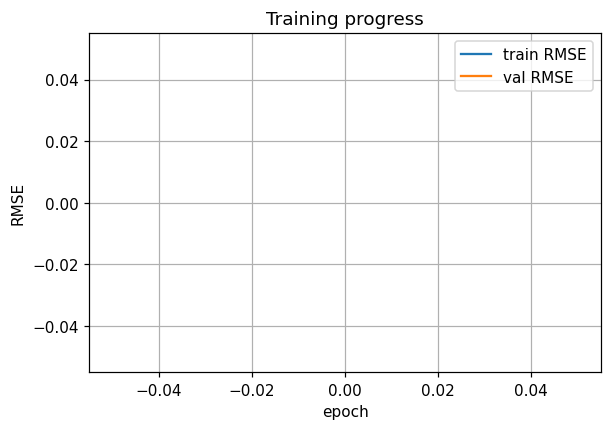

Epoch 1:   0%|          | 0/73 [00:00<?, ?day/s]

In [ ]:
best_val_rmse = custom_stateful_training_loop(
                                            model=model,
                                            ds_train=ds_train,
                                            ds_val=ds_val,
                                            max_epochs=max_epochs,
                                            early_stop_patience=early_stop_patience,
                                            lr_reduce_patience=lr_reduce_patience,
                                            min_lr=min_lr,
                                            ckpt_path=ckpt_path
                                            )
best_val_rmse